In [14]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import numpy as np
import matplotlib.pyplot as plt

In [15]:
X, y = shap.datasets.california()

In [16]:
print(f"Median house prices : {round(y.mean(), 2)}")

Median house prices : 2.07


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Linear Regression

In [18]:
numerical_features = [c for c in X_train.columns]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num,df_out=True)
preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = add_constant(preprocessed_X_train)
reg = OLS(y_train, preprocessed_X_train).fit()

In [19]:
def evaluate(X, y, mapper=None, reg=None, transform=False):
    if transform:
        X = mapper.transform(X)
        X = add_constant(X, has_constant='add')
    y_pred = reg.predict(X)
    return mean_absolute_error(y, y_pred)

In [20]:
train_mae = evaluate(X_train, y_train, mapper, reg, True)
test_mae = evaluate(X_test, y_test, mapper, reg, True)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)}")

train MAE = 0.543, test MAE = 0.435


In [21]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     3462.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:08:55   Log-Likelihood:                -20753.
No. Observations:               18576   AIC:                         4.152e+04
Df Residuals:                   18567   BIC:                         4.160e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1203      0.005    390.666      0.000       2.110       2.131
MedInc         0.8550      0.009     99.349      0.000       0.838       0.872
HouseAge       0.1247      0.006     20.528      0.000       0.113       0.137
AveRooms      -0.2896      0.016    -18.039      0.000      -0.321      -0.258
AveBedrms      0.3306      0.015     22.514      0.000       0.302       0.359
Population    -0.0019      0.006     -0.334      0.738      -0.013       0.009
AveOccup      -0.0342      0.005     -6.268      0.000      -0.045      -0.023
Latitude      -0.8905      0.017    -53.016      0.000      -0.923      -0.858
Longitude     -0.8902      0.017    -53.347      0.000      -0.923      -0.858
==============================================================================
Omnibus:                     3814.037   Durbin-Watson:                   0.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12335.113
Skew:                           1.041   Prob(JB):                         0.00
Kurtosis:                       6.406   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Random Forest

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
numerical_features = [c for c in X_train.columns]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num,df_out=True)
reg = RandomForestRegressor()
pipeline = Pipeline([('preprocess', mapper),
                  ('reg', reg)])
p = pipeline.fit(X_train, y_train)

train_mae = evaluate(X_train, y_train, reg=pipeline)
test_mae = evaluate(X_test, y_test,  reg=pipeline)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)}")

train MAE = 0.119, test MAE = 0.338


<BarContainer object of 8 artists>

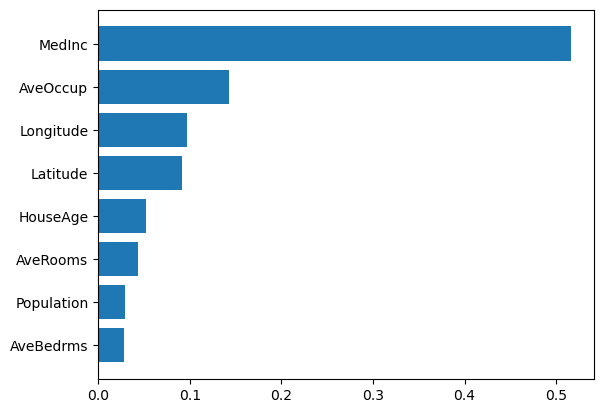

In [25]:
sorted_idx = reg.feature_importances_.argsort()
features = numerical_features
result = sorted(zip(features, reg.feature_importances_), key = lambda x: x[1], reverse=False)
plt.barh([x[0] for x in result], [x[1] for x in result])

## Neural Network

In [29]:
from torch.autograd import Variable 
import torch
import torch.nn as nn
import torch.optim as optim

preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50 
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch, dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print("Epoch {}, Loss: {}".format(epoch, running_loss))

preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)}")

Epoch 0, Loss: 403.47326650097966
Epoch 10, Loss: 230.01004400104284
Epoch 20, Loss: 221.3890454992652
Epoch 30, Loss: 217.19272910803556
Epoch 40, Loss: 244.90944639220834
train MAE = 0.605, test MAE = 0.53


We don't have a direct way to identify feature importance for neural networks

## Problems with Interpretation
- No specific method to define feature importance that is model agnostic
- For a given sample, why does the prediction have that value?

Answer: Shap values

## Intuition of Model Interpretation

How we think about answering the question "Why is the output for this specific sample so low/high" manually?

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) #revert
numerical_features = [c for c in X_train.columns]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num, df_out=True)
reg = LinearRegression()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

In [31]:
nan_frame = pd.DataFrame(columns=numerical_features, index=[0])
nan_frame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
base_value = round(pipeline.predict(nan_frame)[0], 3)
print(f"Expected value of the output (base value): {base_value}")

Expected value of the output (base value): 2.12


In [36]:
X_test.iloc[1: 2]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
18577,2.4375,20.0,4.790741,1.012963,1534.0,2.840741,36.93,-121.77


In [37]:
sample_prediction = round(pipeline.predict(X_test.iloc[1: 2])[0], 3)
print(f"Current Prediction: {sample_prediction}, Actual value: {y_test[0]}")

Current Prediction: 1.797, Actual value: 1.214


## Partial Dependence Plots

In [38]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

ExactExplainer explainer: 2065it [00:33, 48.54it/s]                                                                    


In [39]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

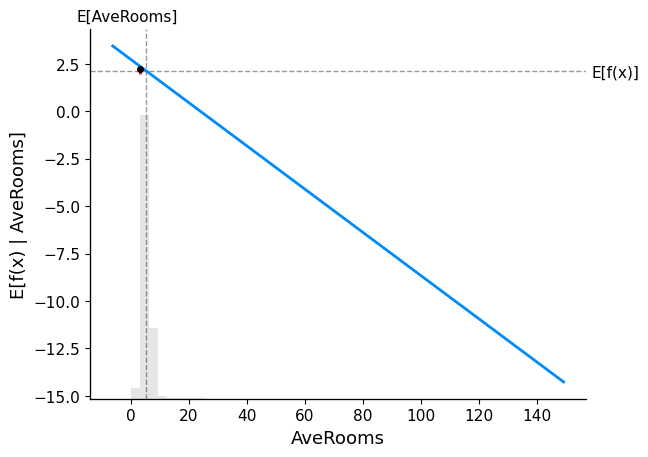

In [40]:
partial_dependence_plot('AveRooms', 0)

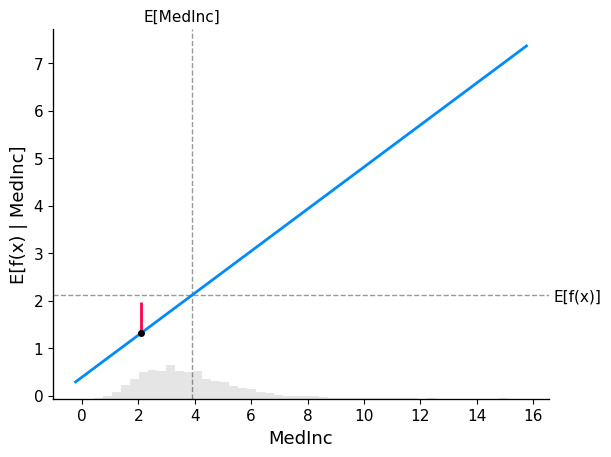

In [42]:
partial_dependence_plot('MedInc', 0)

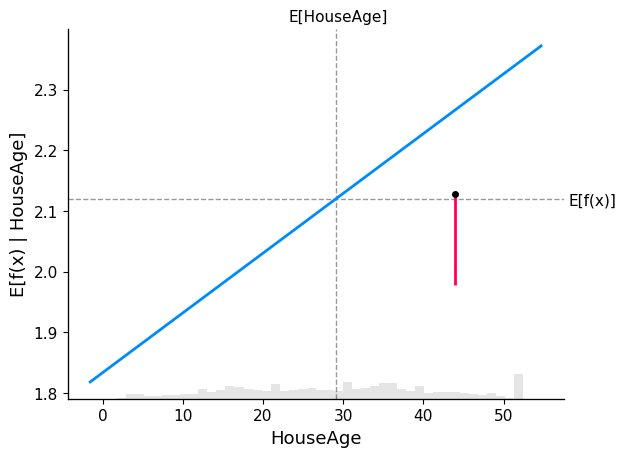

In [43]:
partial_dependence_plot('HouseAge', 0)

## Shap Plots

Hard to look at every feature for every sample. So lets look at all features of the same sample

In [44]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

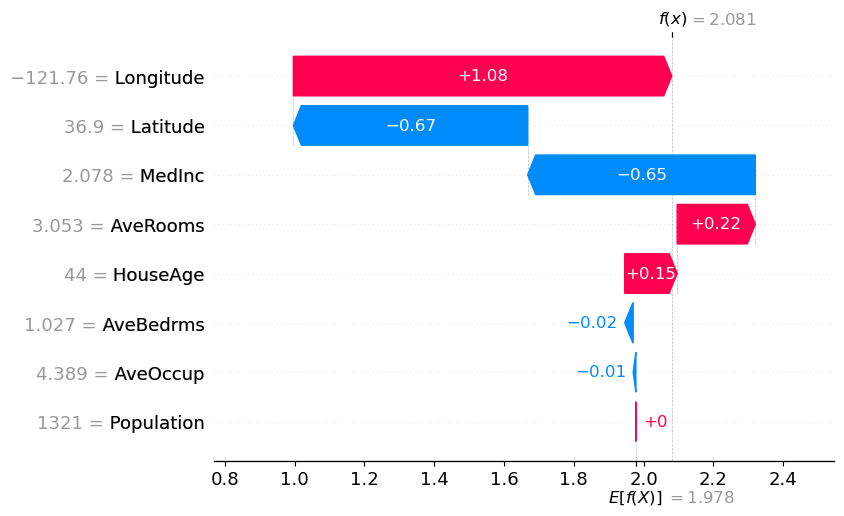

In [45]:
sample_feature_importance(0, 'waterfall')

In [46]:
sample_feature_importance(0, 'condensed')

## Feature Importance for model

Looking at individual samples can be a bother. Let's look at all samples together

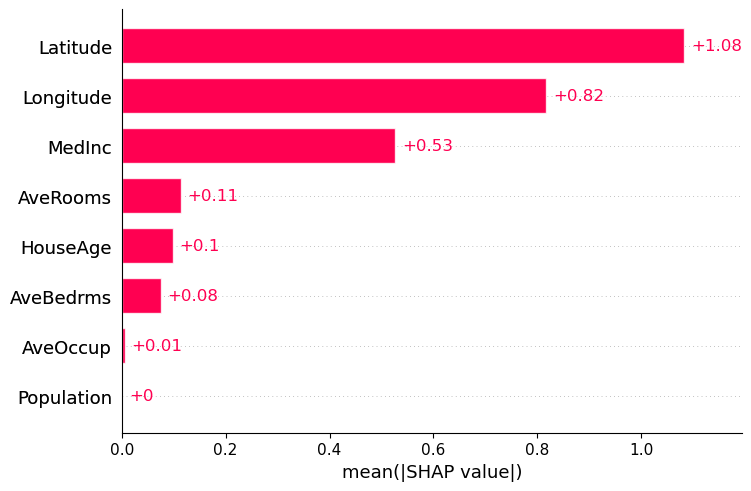

In [47]:
shap.plots.bar(shap_values)

Two most important features according to the LinearRegression model:
- Latitude
- Longitude

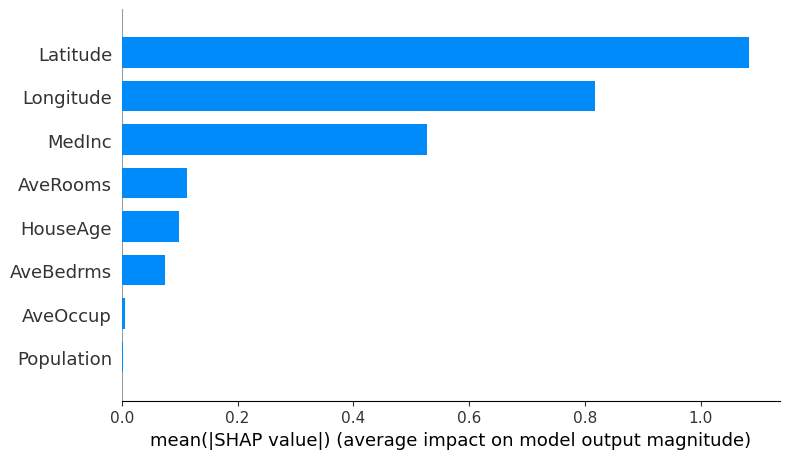

In [48]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

We can interpret the neural network model in the same way

In [49]:
preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 374.8223796579987
Epoch 10, Loss: 259.91964234411716
Epoch 20, Loss: 248.34439527615905
Epoch 30, Loss: 217.47018236666918
Epoch 40, Loss: 219.50336526334286

train MAE = 0.624, test MAE = 0.528 


In [51]:
explainer = shap.DeepExplainer(model, torch.from_numpy(preprocessed_X_train.values).float())
shap_values = explainer.shap_values(torch.from_numpy(preprocessed_X_test.values).float())

<Figure size 640x480 with 0 Axes>

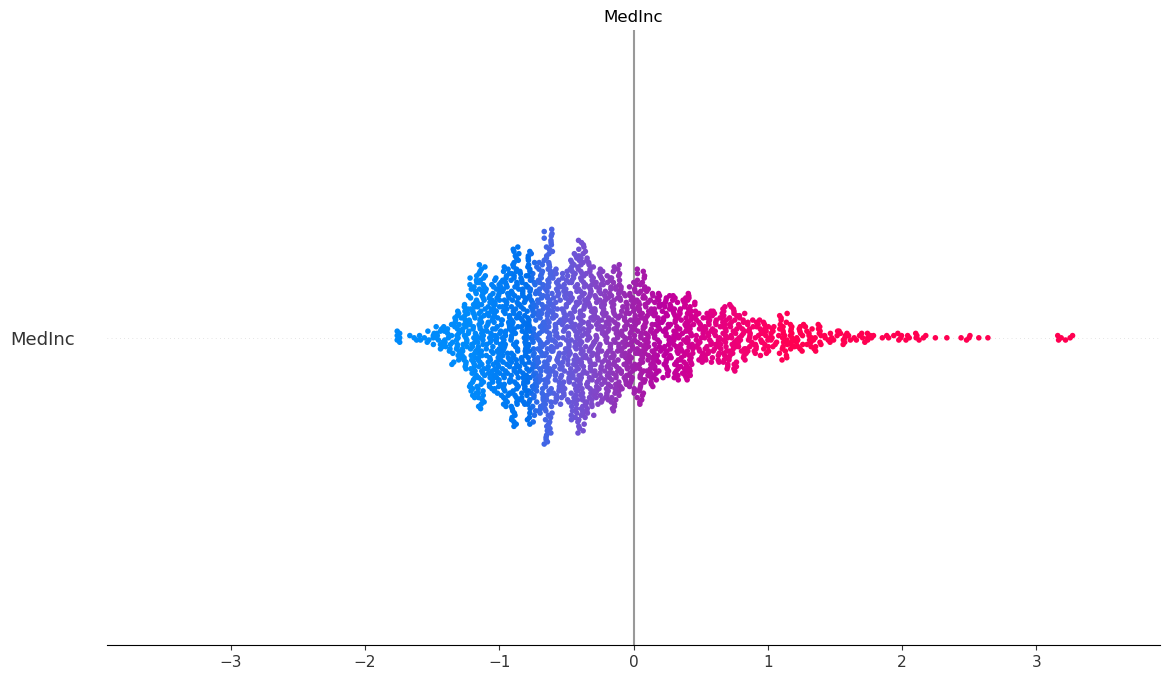

In [53]:
shap.summary_plot(shap_values, X_test, plot_type='bar')